In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
import random
import os
from IPython.display import HTML

---

In [45]:
class test:
    def __init__(self,file_path) -> None:
        self.G = self.read_graph(file_path)
    
    def read_graph(self,file_path):
            G = nx.Graph() 
            with open(file_path, 'r') as file:
                for line in file:
                    node1, node2 = map(int, line.split()) 
                    G.add_edge(node1, node2)
            return G

    def display_graph(self):
        plt.figure(figsize=(10, 10)) 
        pos = nx.spring_layout(self.G, k=0.5, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10) 
        plt.show()
    
    def assign_colors_to_nodes(self, circle_file):
        node_colors = {}  
        circles = []  
        
        with open(circle_file, 'r') as file:
            for line in file:
                parts = line.strip().split() 
                nodes_in_circle = parts[1:] 
                circles.append(nodes_in_circle)

        num_circles = len(circles)
        cmap = plt.get_cmap('hsv')
        colors = [cmap(i / num_circles) for i in range(num_circles)] 
        

        for color_index, nodes_in_circle in enumerate(circles):
            for node in nodes_in_circle:
                node_colors[node] = colors[color_index] 

        for node in self.G.nodes:
            self.G.nodes[node]['color'] = node_colors.get(str(node), (0.5, 0.5, 0.5)) 
        
        self.display_colored_graph(self.G)
    

    def display_colored_graph(self,graph):
        node_colors = [graph.nodes[node].get('color', (0.5, 0.5, 0.5)) for node in graph.nodes] 
        plt.figure(figsize=(10, 10))
        pos = nx.spring_layout(graph, k=0.5, seed=42)  
        nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=500, font_size=10)
        plt.show()
    

    def color_random_nodes_red(self, graph=None):
        if graph is None:
            graph = self.G.copy()

        # Ensure we have a list of all nodes in the provided graph
        all_nodes = list(graph.nodes())
        num_red_nodes = random.randint(3, 10)
        red_nodes = random.sample(all_nodes, num_red_nodes)

        # Set colors for randomly selected red nodes
        for node in red_nodes:
            if node in graph.nodes:  # Check if node exists in the graph
                graph.nodes[node]['color'] = 'red'

        # Set the color of all other nodes to gray
        for node in graph.nodes:
            if node not in red_nodes:  # Only set if not in red nodes
                graph.nodes[node]['color'] = 'gray'

        return graph
    
    def create_connected_graph(self,num_nodes=100):
        G = nx.Graph()
        
        # Add nodes from 1 to num_nodes
        G.add_nodes_from(range(1, num_nodes + 1))
        
        # Choose main nodes in each cluster
        main_node_1 = 5
        main_node_2 = 15
        
        # Add edges for the main nodes with random connections within clusters
        cluster_1_nodes = random.sample(range(1, num_nodes // 2 + 1), k=random.randint(20, 30))
        cluster_2_nodes = random.sample(range(num_nodes // 2 + 1, num_nodes + 1), k=random.randint(20, 30))
        
        edges_1 = [(main_node_1, i) for i in cluster_1_nodes if i != main_node_1]
        edges_2 = [(main_node_2, i) for i in cluster_2_nodes if i != main_node_2]
        
        G.add_edges_from(edges_1 + edges_2)
        
        # Add random cross-connections between the two clusters
        cross_edges = [(random.choice(cluster_1_nodes), random.choice(cluster_2_nodes)) for _ in range(10)]
        G.add_edges_from(cross_edges)
        
        # Ensure the graph is connected
        if not nx.is_connected(G):
            # Find all disconnected components and connect them
            components = list(nx.connected_components(G))
            for i in range(1, len(components)):
                # Pick one node from each disconnected component and connect them
                node_from_comp1 = random.choice(list(components[i - 1]))
                node_from_comp2 = random.choice(list(components[i]))
                G.add_edge(node_from_comp1, node_from_comp2)
        
        return G

    def save_random_graphs(self, num):
        output_dir = "graphs_images"
        os.makedirs(output_dir, exist_ok=True)

        for i in range(num):
            # Create a connected graph with 100 nodes
            G = self.create_connected_graph(num_nodes=100)
            node_colors = ['blue' if node <= 50 else 'green' for node in G.nodes]
            pos = nx.spring_layout(G, seed=42)  # Fix layout for consistency

            # Copy the graph to identify top nodes
            test_graph = G.copy()
            
            # returns the top 2 most influential nodes
            # top_nodes = get_most_influential_nodes(model=None, graph=test_graph, top_k=2)

            # Plot the graph
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

            # First subplot: the original graph
            plt.sca(axes[0])
            nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=300, font_color='white', font_size=8)
            plt.title(f"Connected Graph {i + 1}")

            # Second subplot: graph with top nodes marked
            
            result =  self.color_random_nodes_red(test_graph)
            result_node_colors = [result.nodes[node]['color'] for node in result.nodes]


            plt.sca(axes[1])
            nx.draw(result, pos, with_labels=True,node_color=result_node_colors, node_size=300, font_color='white', font_size=8)
            plt.title(f"Graph with Top Nodes Highlighted")

            fig.tight_layout()
            
            # Save the figure
            file_path = os.path.join(output_dir, f"graph_{i + 1}.png")
            plt.savefig(file_path)
            
            # Show the plot
            plt.show()
            
            # Close the plot to free up memory
            plt.close()

        print(f"Connected graphs saved in the '{output_dir}' directory.")
    
    def simulator(self):
        def simulate_message_spread_with_delay(graph, start_nodes):
            visited_nodes = set()
            nodes_by_step = []

            # Queue for BFS
            queue = deque(start_nodes)
            visited_nodes.update(start_nodes)
            nodes_by_step.append(set(start_nodes))

            while queue:
                next_step_nodes = set()
                # For each node in the current queue, add its neighbors to the next step
                for _ in range(len(queue)):
                    node = queue.popleft()
                    neighbors = set(graph.neighbors(node)) - visited_nodes  # Unvisited neighbors
                    next_step_nodes.update(neighbors)
                
                if next_step_nodes:
                    nodes_by_step.append(next_step_nodes)
                    queue.extend(next_step_nodes)
                    visited_nodes.update(next_step_nodes)
            
            return nodes_by_step

        def update(num, graph, pos, nodes_by_step, ax, node_colors):
            ax.clear()
            
            # Draw nodes that are yet to be reached
            nx.draw(graph, pos, node_color=node_colors, with_labels=True, ax=ax, node_size=500)
            
            # Highlight nodes reached in this step
            reached_nodes = set()
            for i in range(num + 1):
                reached_nodes.update(nodes_by_step[i])
            
            # Set color of reached nodes
            reached_colors = ['green' if node in reached_nodes else 'lightblue' for node in graph.nodes()]
            nx.draw(graph, pos, node_color=reached_colors, with_labels=True, ax=ax, node_size=500)

        def animate_spread(graph, start_nodes):
            nodes_by_step = simulate_message_spread_with_delay(graph, start_nodes)

            fig, ax = plt.subplots(figsize=(8, 8))  # Increase figure size for better visibility
            pos = nx.spring_layout(graph, k=0.9)  # Increase the spacing between nodes
            node_colors = ['lightblue'] * len(graph.nodes())
            
            ani = animation.FuncAnimation(
                fig, update, frames=len(nodes_by_step), fargs=(graph, pos, nodes_by_step, ax, node_colors),
                interval=1000, repeat=False
            )
            
            return ani

    
        graph = self.read_graph('../12831.edges')
        print(type(graph))  # Check if this outputs <class 'networkx.classes.graph.Graph'>
        # start_nodes = [13927832, 7899982, 180505807, 22229621, 353101127]
        start_nodes = [16004268]

        print("No of nodes that got the message : ",len(simulate_message_spread_with_delay(graph, start_nodes)))

        ani = animate_spread(graph, start_nodes)
        display(HTML(ani.to_jshtml())) 
        # ani = animate_spread(graph, start_nodes)


---

## Input Graph

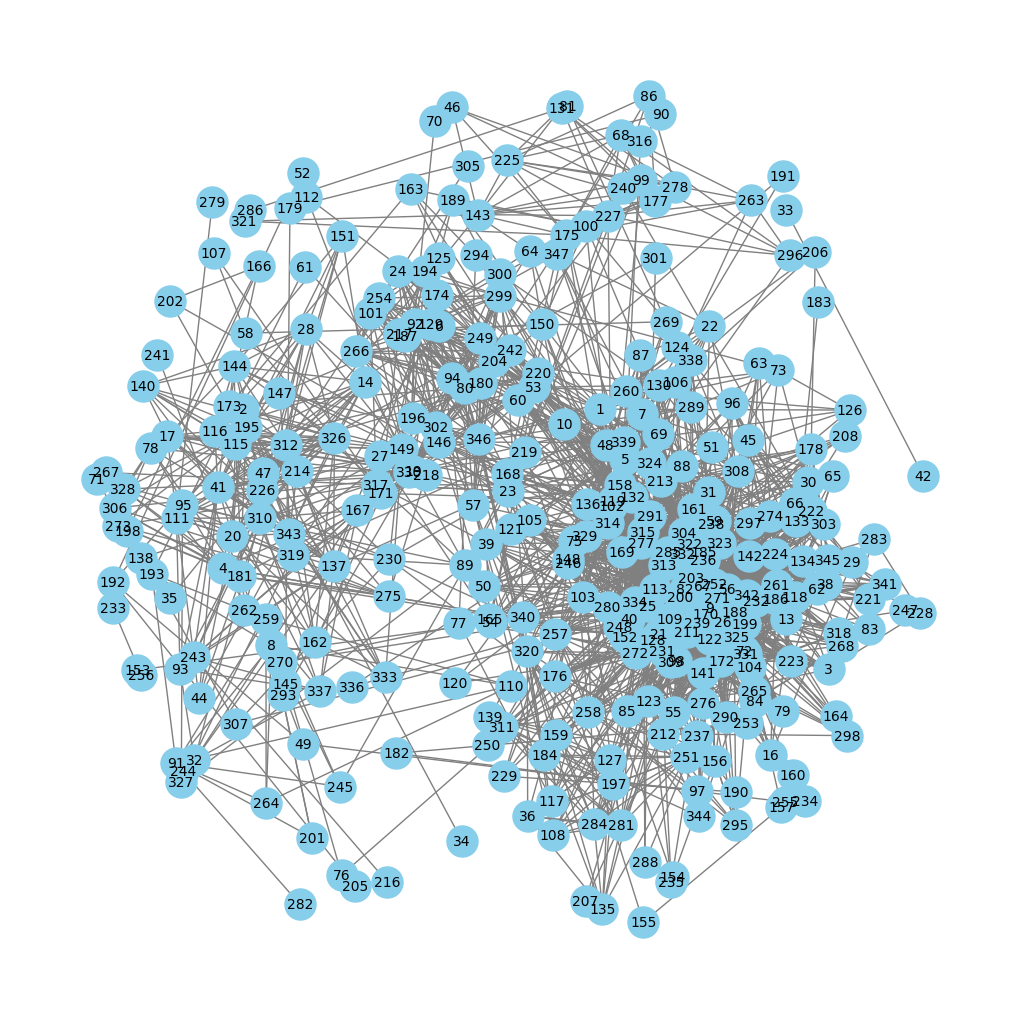

In [46]:
test = test("../dataset/0.edges")

test.display_graph()

## Identfying the Circles

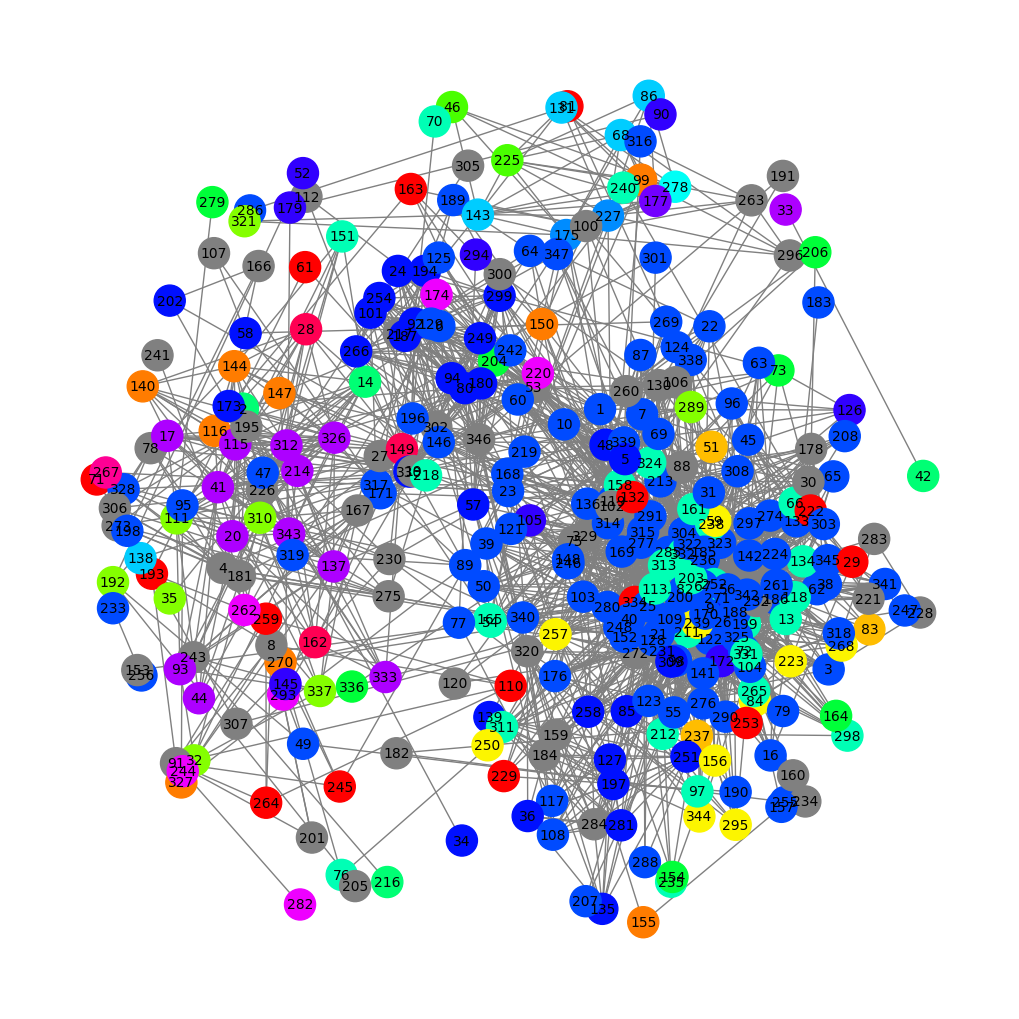

In [47]:
test.assign_colors_to_nodes('../dataset/0.circles')

## Output Graph

In [48]:
test.color_random_nodes_red()

---

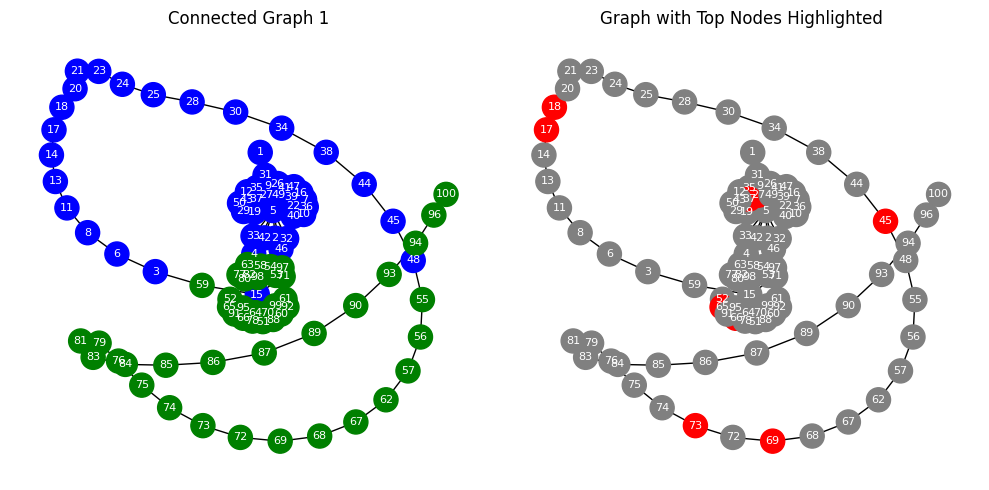

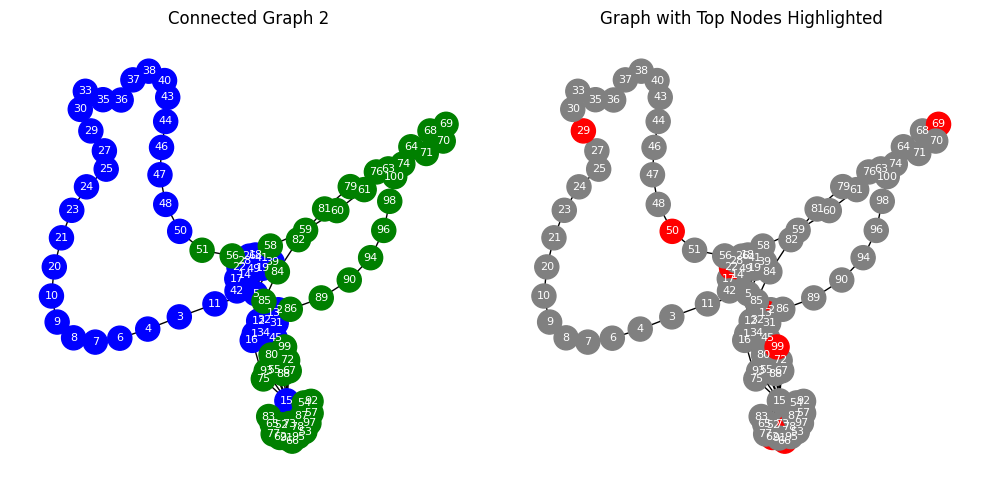

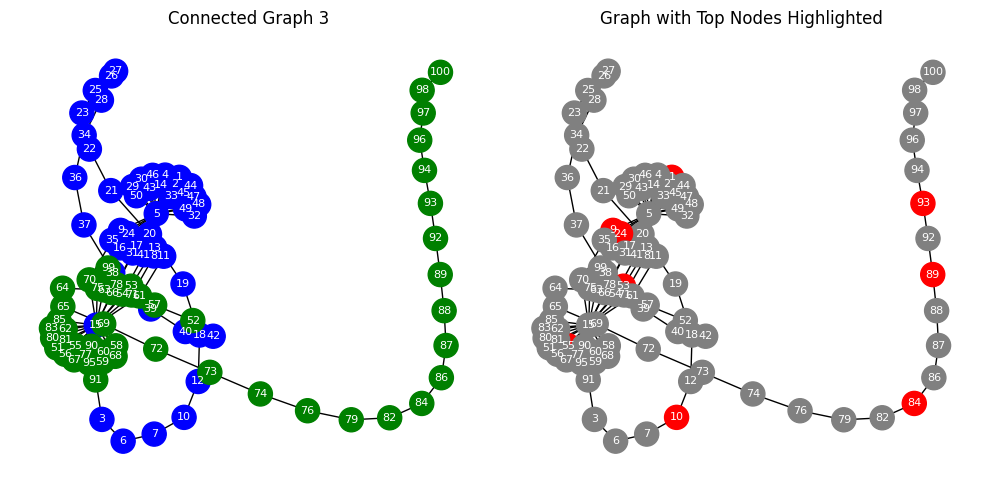

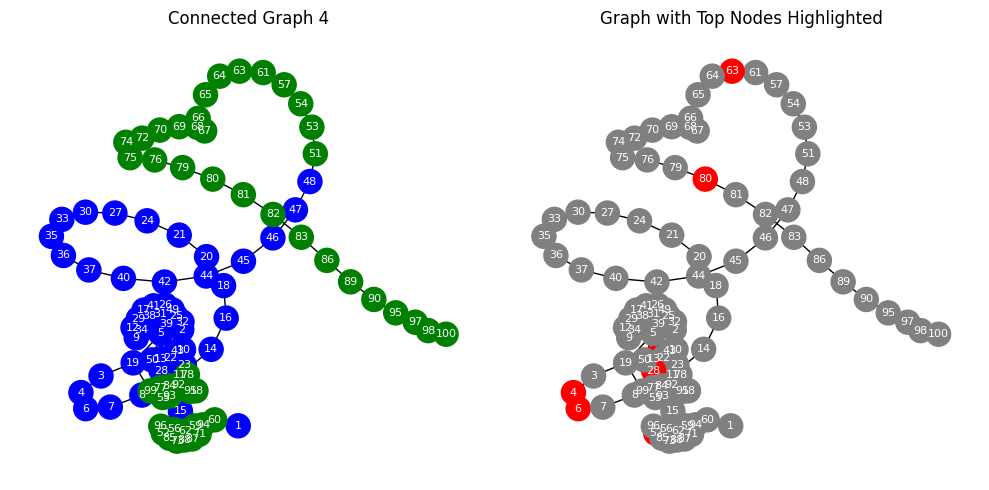

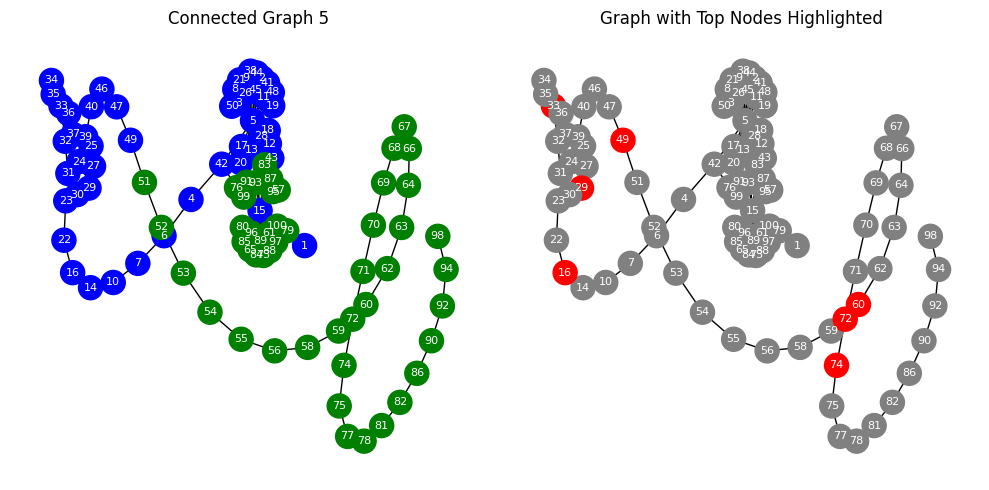

Connected graphs saved in the 'graphs_images' directory.


In [49]:
test.save_random_graphs(5)

<class 'networkx.classes.graph.Graph'>
No of nodes that got the message :  5


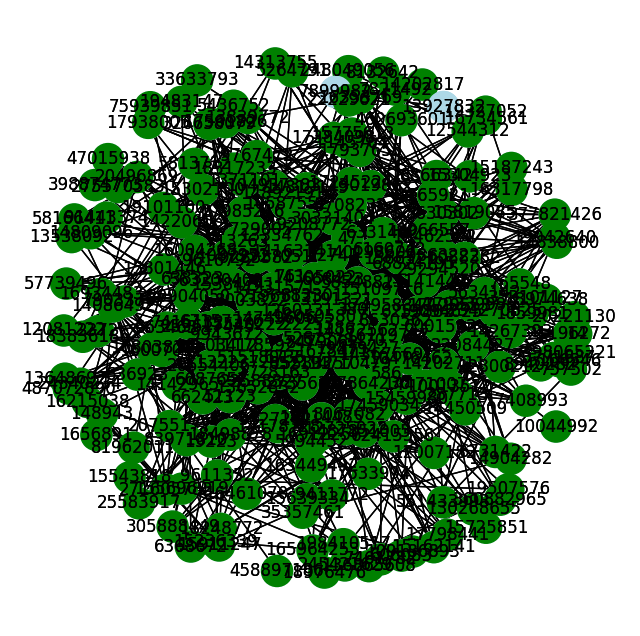

In [50]:
test.simulator()